In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, History

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Load dataset
df = pd.read_csv('HR_comma_sep.csv')

In [3]:
# View a sample of the loaded data
df.sample(5)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Departments,salary
7129,0.98,0.74,4,202,3,0,0,0,accounting,low
7254,0.73,0.91,4,241,2,1,0,0,accounting,medium
11218,0.95,0.84,3,261,8,1,0,1,hr,medium
13670,0.84,0.73,4,197,3,0,0,1,technical,low
13448,0.24,0.50,4,282,4,1,0,0,support,low



**satisfaction_level**: It is employee satisfaction point, which ranges from 0-1.

**last_evaluation**: It is evaluated performance by the employer, which also ranges from 0-1.

**number_projects**: How many numbers of projects assigned to an employee?

**average_monthly_hours**: How many average numbers of hours worked by an employee in a month?

**time_spent_company**: time_spent_company means employee experience. The number of years spent by an employee in the company.

**work_accident**: Whether an employee has had a work accident or not.

**promotion_last_5years**: Whether an employee has had a promotion in the last 5 years or not.

**Departments**: Employee's working department/division.

**Salary**: Salary level of the employee such as low, medium and high.

**left**: Whether the employee has left the company or not.


In [4]:
# Replacing 1 with Yes and 0 with No in the 'left' column
df['left'] = df['left'].map({1:'yes', 0:'no'})
df.sample(5)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Departments,salary
6257,0.19,0.63,5,206,6,0,no,0,RandD,medium
7518,0.85,0.55,5,182,3,0,no,0,technical,low
14990,0.89,0.88,5,228,5,1,yes,0,support,low
2748,0.20,0.74,6,148,4,0,no,0,marketing,low
5613,1.00,0.54,3,151,2,1,no,0,technical,low


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null object
promotion_last_5years    14999 non-null int64
Departments              14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(5), object(3)
memory usage: 1.1+ MB


no     11428
yes     3571
Name: left, dtype: int64

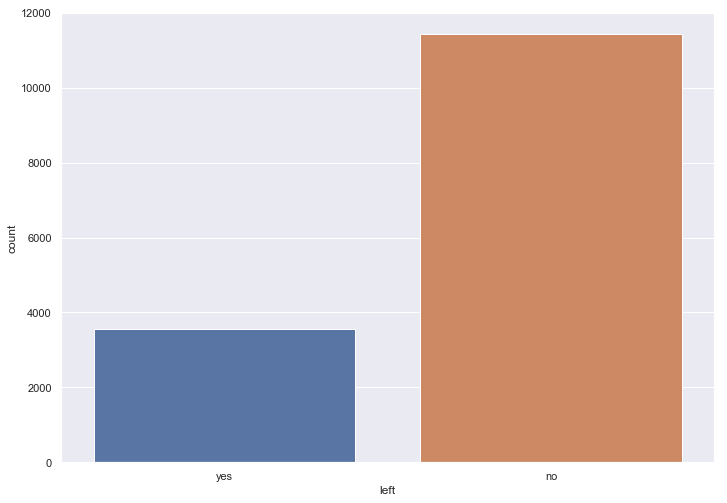

In [6]:
# Visualize the number of employees who left the company
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot('left', data=df)

df['left'].value_counts()

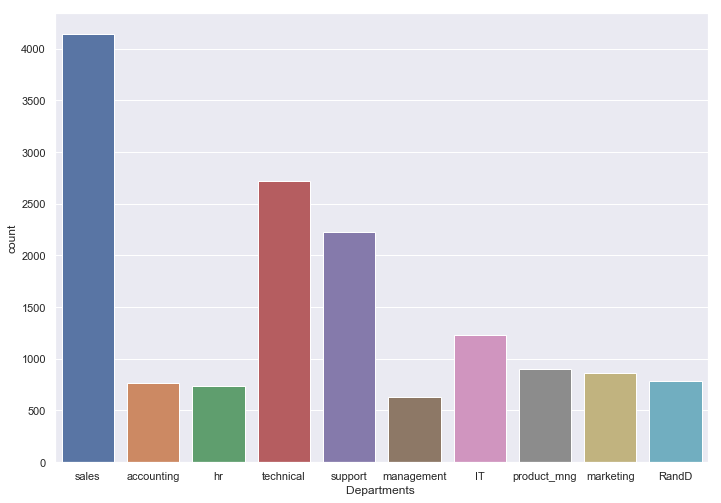

In [7]:
# Number of employees per department
sns.countplot(df['Departments '])

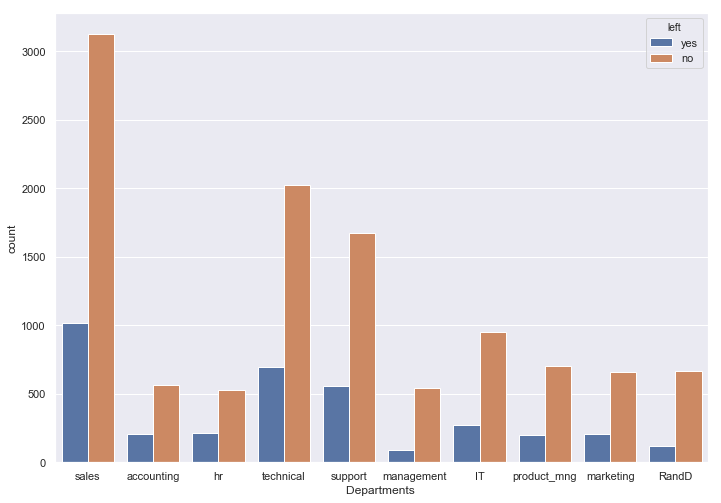

In [8]:
# Number of employees who left per department
sns.countplot(df['Departments '], hue=df['left'])

0    14680
1      319
Name: promotion_last_5years, dtype: int64

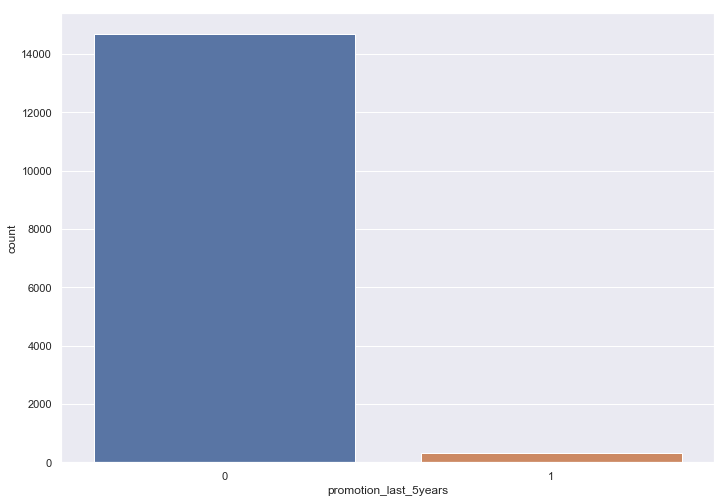

In [9]:
# Number of employees promoted in the last 5 years
sns.countplot(df['promotion_last_5years'])

df['promotion_last_5years'].value_counts()

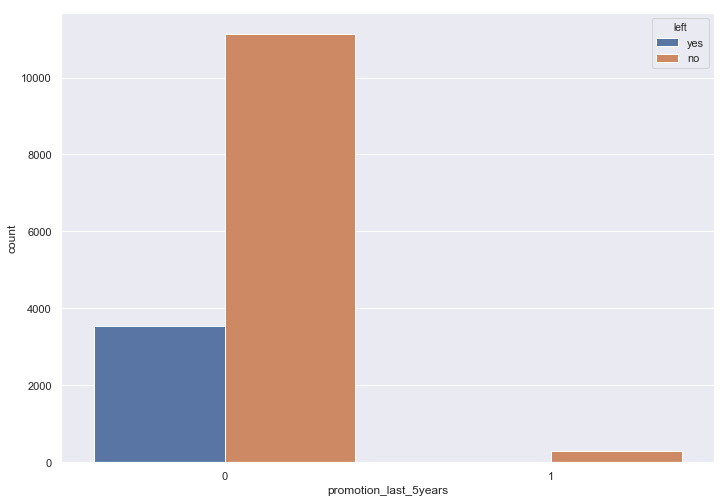

In [10]:
# Number of employees promoted in the last 5 years who left
sns.countplot(df['promotion_last_5years'], hue=df['left'])

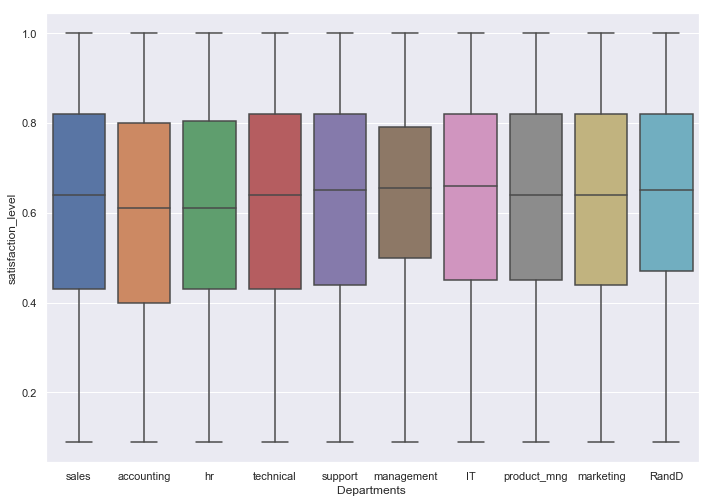

In [11]:
# Average job satisfaction level per department
sns.boxplot('Departments ', 'satisfaction_level', data=df)

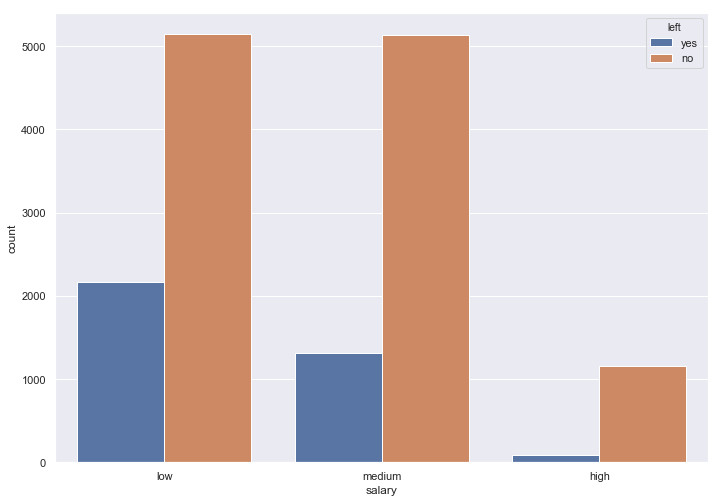

In [12]:
# Relationship between employee earnings and them leaving
sns.countplot('salary', hue='left', data=df)

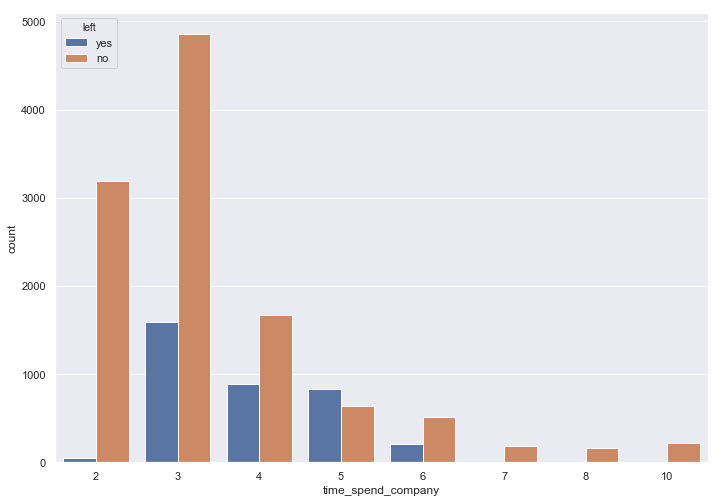

In [13]:
# Relationship between time spent in the company and them leaving
sns.countplot(df['time_spend_company'], hue=df['left'])

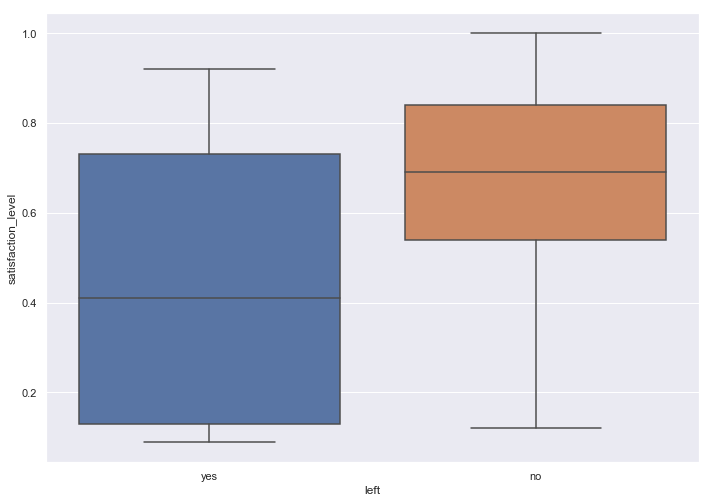

In [14]:
# Relationship between job satisfaction and them leaving
sns.boxplot('left', 'satisfaction_level', data=df)

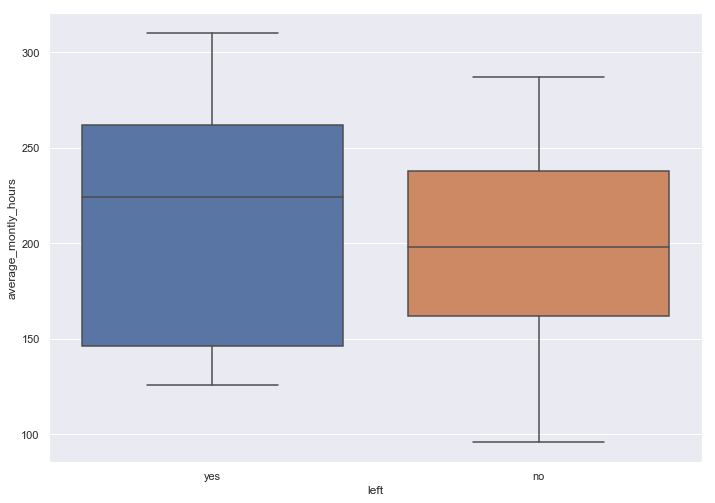

In [15]:
# Relationship between number of hours worked monthly and them leaving
sns.boxplot('left', 'average_montly_hours', data=df)

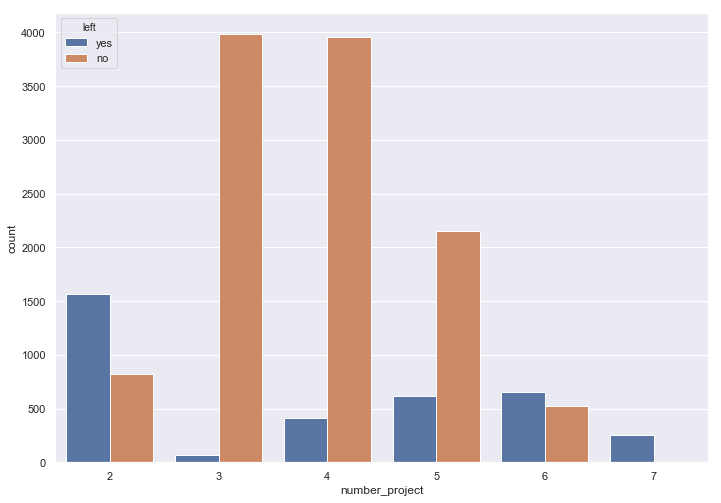

In [16]:
# Relationship between number of projects and them leaving
sns.countplot('number_project', hue='left', data=df)

In [17]:
# Encode text values to indexes
le = preprocessing.LabelEncoder()

df['salary'] = le.fit_transform(df['salary'])
df['Departments '] = le.fit_transform(df['Departments '])
df['left'] = le.fit_transform(df['left'])

In [18]:
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)


x, y = to_xy(df, "left")
x = preprocessing.StandardScaler().fit(x).transform(x.astype(float))


C:\Users\bmwandau\Anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [19]:
# Split dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=7)
print('Train set:', x_train.shape, y_train.shape)
print('Test set:', x_test.shape, y_test.shape)

Train set: (11999, 9) (11999, 2)
Test set: (3000, 9) (3000, 2)


In [20]:
# Defining the Multilayer Perceptron for Binary Classification
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

In [21]:
# Model architecture and parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               1000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
__________

In [22]:
# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
# Validation monitor
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')

# Save best model
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True)

In [24]:
# Fitting/Training the model
history = model.fit(x_train, y_train, validation_split=0.2, callbacks=[monitor, checkpointer], verbose=0, epochs=1000, batch_size=64)

# Load weights from best model
model.load_weights('best_weights.hdf5')

Epoch 00031: early stopping


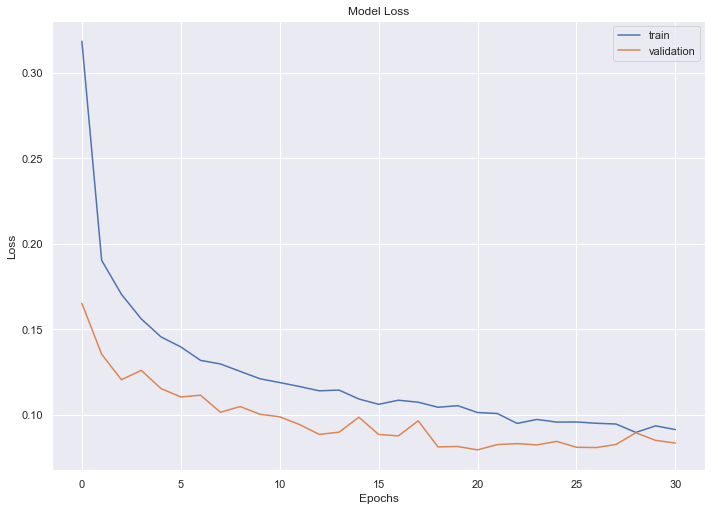

In [25]:
# Model Loss over time
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

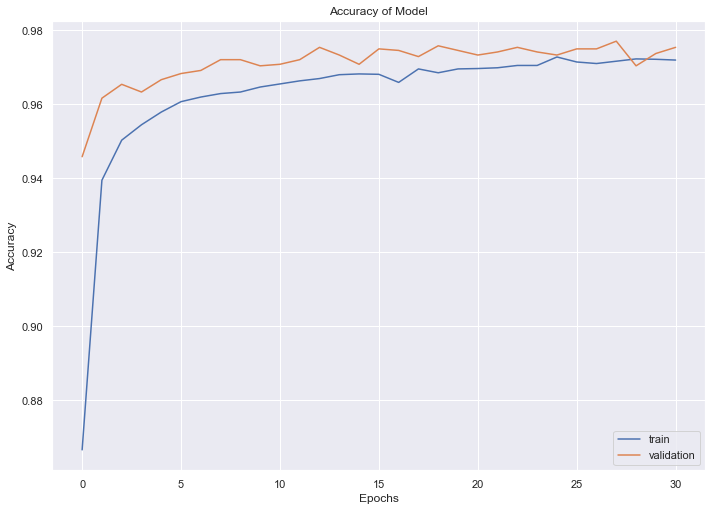

In [26]:
# Model Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy of Model')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [27]:
pred = model.predict(x_test)
pred = np.argmax(pred, axis=1)
y_compare = np.argmax(y_test, axis=1)
score = metrics.accuracy_score(y_compare, pred)
print("Final accuracy: {}".format(score*100))

Final accuracy: 96.86666666666667


[[2287   30]
 [  64  619]]


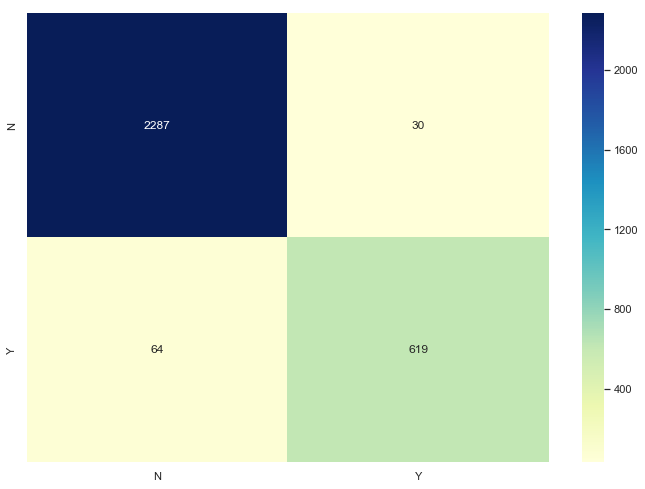

In [28]:
# Plot a confusion matrix

cm = confusion_matrix(y_compare, pred)
np.set_printoptions(precision=2)
print(cm)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels='NY', yticklabels='NY')

In [29]:
# Display the Classification Report

print('Classification report: \n\n',classification_report(y_compare, pred))

Classification report: 

               precision    recall  f1-score   support

           0       0.97      0.99      0.98      2317
           1       0.95      0.91      0.93       683

   micro avg       0.97      0.97      0.97      3000
   macro avg       0.96      0.95      0.95      3000
weighted avg       0.97      0.97      0.97      3000



**Precision**: How often the model is correct when making a prediction

**Recall**: How often the model can identify when an employee leaves the company

**F1-Score**: The weighted harmonic mean of the precision and recall of the test